In [1]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [2]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline


# utils
import numpy as np
from torchsummary import summary
import time
import copy

from tqdm.notebook import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

import torch
from torch import nn, optim
from torch.backends import cudnn
cudnn.benchmark = True
from randaugment import RandAugment, ImageNetPolicy
import random

In [3]:
def display_images():
    fig, subplots = plt.subplots(1,5, figsize=(13,6))
    for i in range(5):
        axil = subplots.flat[i]
        original_img = Image.fromarray(cifar10.data[i])
        axil.imshow(original_img)
        axil.set_title('original_img')

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
# 데이터셋의 루트 디렉터리와 이미지 폴더를 지정합니다.
root_dir = '../data/'  # 데이터셋의 루트 디렉터리 경로
train_folder = 'kfood_train/train'  # 이미지가 있는 폴더의 이름
val_folder = 'kfood_val/val'  # 이미지가 있는 폴더의 이름

In [6]:
# 이미지 전처리를 위한 변환(transform)을 정의합니다.
transform = transforms.Compose([
    transforms.Resize((244, 244)),  # 이미지 크기를 조절합니다.
    transforms.ToTensor(),  # 이미지를 Tensor로 변환합니다.
])

In [7]:
# 데이터셋을 불러옵니다.
train_ds = torchvision.datasets.ImageFolder(
    root=root_dir + train_folder,
    transform=transform
)

In [8]:
# 데이터셋을 불러옵니다.
val_ds = torchvision.datasets.ImageFolder(
    root=root_dir + val_folder,
    transform=transform
)

In [9]:
# train_ds의 데이터 수 
print(len(train_ds))

33593


In [10]:
# val_ds의 데이터 수 
print(len(val_ds))

4198


In [11]:
# # 이미지를 정규화(평균,분산)
# train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
# train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]
# 
# train_meanR = np.mean([m[0] for m in train_meanRGB])
# train_meanG = np.mean([m[1] for m in train_meanRGB])
# train_meanB = np.mean([m[2] for m in train_meanRGB])
# train_stdR = np.mean([s[0] for s in train_stdRGB])
# train_stdG = np.mean([s[1] for s in train_stdRGB])
# train_stdB = np.mean([s[2] for s in train_stdRGB])
# 
# val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_ds]
# val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_ds]
# 
# val_meanR = np.mean([m[0] for m in val_meanRGB])
# val_meanG = np.mean([m[1] for m in val_meanRGB])
# val_meanB = np.mean([m[2] for m in val_meanRGB])
# 
# val_stdR = np.mean([s[0] for s in val_stdRGB])
# val_stdG = np.mean([s[1] for s in val_stdRGB])
# val_stdB = np.mean([s[2] for s in val_stdRGB])
# 
# print(train_meanR, train_meanG, train_meanB)
# print(val_meanR, val_meanG, val_meanB)

In [12]:
# print(train_meanR, train_meanG, train_meanB)
# print(val_meanR, val_meanG, val_meanB)
# print(train_stdR,train_stdG ,train_stdB)
# print(val_stdR,val_stdG,val_stdB)

In [13]:
# 위의 코드를 실행하면 나오는 평균과 분산 (편의를 위하여 변수로 저장)
train_meanR=0.58394545
train_meanG=0.51387334
train_meanB=0.42269564
val_meanR=0.58470017
val_meanG=0.51500267
val_meanB=0.4244054
train_stdR=0.22759153
train_stdG=0.23792826
train_stdB=0.25431448
val_stdR=0.22711068
val_stdG=0.2372811
val_stdB=0.25347996

In [16]:
# define the image transformation
train_transformation = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomAffine(degrees=30, shear=10),
    # Geometric Transformation 적용
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([train_meanR, train_meanG, train_meanB], [train_stdR, train_stdG, train_stdB]),
])

val_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
])

In [17]:
# apply transforamtion
train_ds.transform = train_transformation
val_ds.transform = val_transformation

# create DataLoader
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,num_workers=6)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False,num_workers=6)

In [18]:
# mixup
class MixUp:
    def __init__(self, num_classes, alpha=0.2):
        self.alpha = alpha
        self.num_classes = num_classes

    def __call__(self, images, labels):
        lmbda = np.random.beta(self.alpha, self.alpha)
        batch_size = len(labels)
        index = torch.randperm(batch_size)

        # device 정보 가져오기
        device = images.device
        # 원-핫 인코딩
        labels_a = torch.nn.functional.one_hot(labels, self.num_classes).float().to(device)
        labels_b = torch.nn.functional.one_hot(labels[index], self.num_classes).float().to(device)

        mixed_images = lmbda * images + (1 - lmbda) * images[index, :]
        mixed_labels = lmbda * labels_a + (1 - lmbda) * labels_b

        return mixed_images, mixed_labels


In [19]:
# cutmix
class CutMix:
    def __init__(self, num_classes, beta=1.0, prob=0.5, num_mix=1):
        self.num_classes = num_classes
        self.beta = beta
        self.prob = prob
        self.num_mix = num_mix

    def __call__(self, images, labels):
        # device 정보 가져오기
        device = images.device
        # 원-핫 인코딩
        labels = torch.nn.functional.one_hot(labels, self.num_classes).float().to(device)

        for _ in range(self.num_mix):
            lam = np.random.beta(self.beta, self.beta)
            rand_index = torch.randperm(images.size()[0]).to(device)

            bbx1, bby1, bbx2, bby2 = self.rand_bbox(images.size(), lam)
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))
            labels = labels * lam + labels[rand_index] * (1. - lam)

        return images, labels

    def rand_bbox(self, size, lam):
        W = size[2]
        H = size[3]
        cut_rat = np.sqrt(1. - lam)
        cut_w = np.int(W * cut_rat)
        cut_h = np.int(H * cut_rat)

        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2

In [20]:
# cutmix 와 mixup을 randomchoice 하기 위함
class RandomChoice:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, images, labels):
        transform = random.choice(self.transforms)
        return transform(images, labels)

In [21]:
# cutmix, mixup 선언
cutmix = CutMix(num_classes=42)
mixup = MixUp(num_classes=42)
random_choice = RandomChoice([cutmix, mixup])

image indices: [33003 12172  5192 32511]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


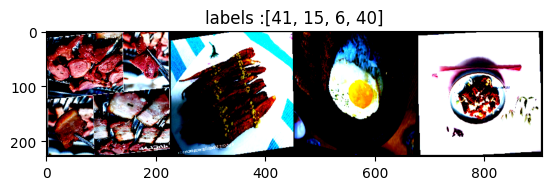

In [23]:
# display sample images 
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels :' + str(y))

np.random.seed(1)
torch.manual_seed(1)

grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print('image indices:',rnd_inds)

x_grid = [train_ds[i][0] for i in rnd_inds]
y_grid = [train_ds[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid, y_grid)

In [24]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [25]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet101().to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output.size())

torch.Size([3, 10])


In [27]:
fc_in_features = model.fc.in_features
model.fc = nn.Linear(fc_in_features, 42)
model = model.to(device)

In [28]:
weight_path = '../weight/101_final3.pth'
# 가중치 로드
model.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

In [29]:
from torchsummary import summary
summary(model, (3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

In [30]:
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [31]:
# lossfunction, optimizer 설정
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.000003)

# Lr schedulr 
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

In [32]:
# function to get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [33]:
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    if len(target.size()) == 1:  # target이 원-핫 인코딩이 아닌 경우
        corrects = pred.eq(target.view_as(pred)).sum().item()
    else:  # target이 원-핫 인코딩인 경우
        target = target.argmax(1, keepdim=True)
        corrects = pred.eq(target).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [34]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    # CutMix와 MixUp 인스턴스 생성
    cutmix = CutMix(num_classes=42)
    mixup = MixUp(num_classes=42, alpha=0.2)

    # RandomChoice 인스턴스 생성
    random_choice = RandomChoice([cutmix, mixup])

    for xb, yb in dataset_dl:

        xb = xb.to(device)
        yb = yb.to(device).long()

        # CutMix나 MixUp 적용
        xb, yb = random_choice(xb, yb)

        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric


In [35]:
# Labelsmoothing 설정
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            if len(target.size()) == 1:  # target이 원-핫 인코딩이 아닌 경우
                true_dist = torch.zeros_like(pred)
                true_dist.fill_(self.smoothing / (self.cls - 1))
                true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            else:  # target이 원-핫 인코딩인 경우
                true_dist = target * self.confidence + (1.0 - target) * self.smoothing / (self.cls - 1)

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))



In [36]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    # # GPU out of memoty error
    # best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')
    best_auc = float(0)
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if 100*val_metric > best_auc:
            best_auc = 100*val_metric
            # best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')
            print('Get best val_auc')

        # lr_scheduler.step(val_loss)
        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    # model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [37]:
# definc the training parameters
params_train = {
    'num_epochs':40,
    'optimizer':opt,
    'loss_func':LabelSmoothingLoss(classes=42, smoothing=0.1),
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'../weight/101_final4.pth',
    
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [38]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/39, current lr=3e-06
Copied best model weights!
Get best val_auc
train loss: 0.023657, val loss: 0.019823, accuracy: 85.11, time: 7.0608 min
----------
Epoch 1/39, current lr=3e-06
train loss: 0.023957, val loss: 0.020360, accuracy: 84.30, time: 14.4232 min
----------
Epoch 2/39, current lr=3e-06
train loss: 0.024214, val loss: 0.019859, accuracy: 84.35, time: 22.4007 min
----------
Epoch 3/39, current lr=3e-06
train loss: 0.024049, val loss: 0.019778, accuracy: 83.90, time: 30.3836 min
----------
Epoch 4/39, current lr=3e-06
train loss: 0.024723, val loss: 0.021406, accuracy: 84.11, time: 38.4932 min
----------
Epoch 5/39, current lr=3e-06
train loss: 0.024716, val loss: 0.020032, accuracy: 84.99, time: 46.6408 min
----------
Epoch 6/39, current lr=3e-06
train loss: 0.024310, val loss: 0.021515, accuracy: 83.44, time: 54.4465 min
----------
Epoch 7/39, current lr=3e-06
Copied best model weights!
Get best val_auc
train loss: 0.023745, val loss: 0.020783, accuracy: 85.71, time: 

KeyboardInterrupt: 

In [42]:
# 최고 accuracy 가중치
weight_path = '../weight/101_final4.pth'
# 가중치 로드
model.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

In [43]:
# 채점시 사용되는 코드
# 본인의 코드에 사용해도 된다.

@torch.no_grad()
def validate_epoch(model: nn.Module, data_loader: DataLoader, device: torch.device):
    ''' data_loader provides inputs and GTs.
        model receives input images from data_loader and produces logits.
        returns the accuracy of model in percent.
    '''
    model.eval()
    accuracies = []
    for images, labels in tqdm(data_loader, total=len(data_loader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        accuracies.append(pred == labels)

    accuracy = torch.concat(accuracies).float().mean() * 100
    return accuracy.item()

In [44]:
validate_epoch(model, val_dl, device)

measuring accuracy:   0%|          | 0/66 [00:00<?, ?it/s]

86.46974182128906